In [1]:
import sys
sys.path.append('../../MembraneQuant')
from membranequant import *
%matplotlib notebook

In [2]:
basepath = '/Users/blandt/Desktop/Data/PAR2 RING mutants experiment 2/Experiment'
paths = direcslist(basepath, 1)
conditions = [p.split('/')[-2].split('_')[1] for p in paths]

imgs = [load_image(p + '/af_corrected.tif') for p in paths]
imgs_flat = [load_image(p + '/af_corrected_flat.tif') for p in paths]
imgs_3channel = [load_image(p + '/af_corrected_3channel.tif') for p in paths]
imgs_3channel_flat = [load_image(p + '/af_corrected_3channel_flat.tif') for p in paths]

rois = [np.loadtxt(p + '/ROI_fit.txt') for p in paths]
cytbg = np.loadtxt('../T2A/cytbg.txt')

imgs = [i for i, c in zip(imgs, conditions) if c == 'nwg325']
rois = [r for r, c in zip(rois, conditions) if c == 'nwg325']

### Image

In [62]:
img = imgs[0]
roi = rois[0]
rotated = rotated_embryo(img, roi, 250, 180, 3)
straight = straighten(img, roi, 50)
straight_itp = straighten(img, roi, 50, ninterp=500)
position = 50

<IPython.core.display.Javascript object>


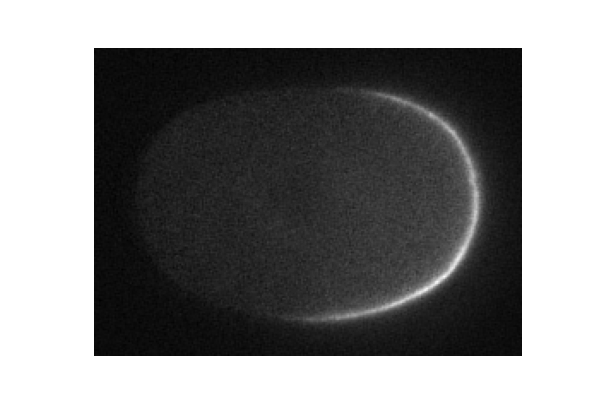

In [63]:
fig, ax = plt.subplots()
ax.imshow(rotated, cmap='gray')
ax.axis('off')
fig.set_size_inches(3,2)
fig.savefig('Figs_method_comparison/img.png', dpi=600, transparent=True)

<IPython.core.display.Javascript object>


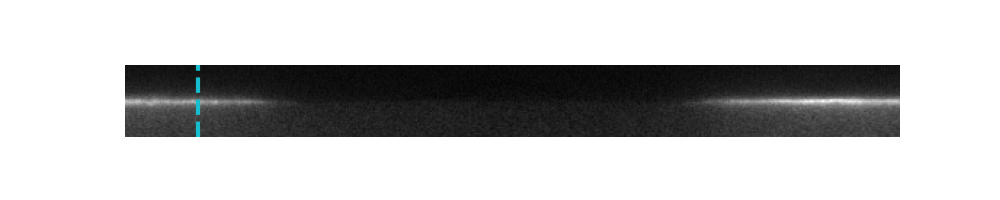

In [57]:
fig, ax = plt.subplots()
ax.imshow(straight, cmap='gray')
ax.axvline(position, linestyle='--', c='tab:cyan')
ax.axis('off')
fig.set_size_inches(5,1)
fig.savefig('Figs_method_comparison/straight.png', dpi=600, transparent=True)

### Method 1: intensity based

<IPython.core.display.Javascript object>


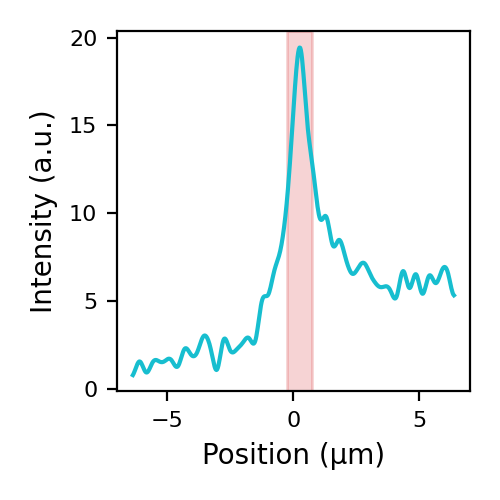

In [61]:
fig, ax = plt.subplots()
x = np.linspace(-25 * 0.255, 25 * 0.255, 500)
ax.plot(x, straight_itp[:, position] / 1000, c='tab:cyan')
ax.set_xlabel('Position (μm)')
ax.set_ylabel('Intensity (a.u.)')
peak = x[np.argmax(straight_itp[:, position])]
ax.tick_params(axis='both', labelsize=8)
ax.axvspan(peak - 0.5, peak + 0.5, alpha=0.2, color='tab:red', zorder=0)
fig.set_size_inches(2.5, 2.5)
fig.tight_layout()
fig.savefig('Figs_method_comparison/method1.png', dpi=600, transparent=True)

### Method 2: fitting based

In [3]:
iq = ImageQuant(img=img, roi=roi, cytbg=cytbg, uni_cyt=True, adaptive_membg=True, 
                batch_norm=False, descent_steps=300, rol_ave=5, lr=0.01, iterations=1, rotate=False,
                interp_type='cubic', roi_knots=20, save_training=True, sigma=2, save_sims=False)
iq.run()

100%|██████████| 300/300 [00:10<00:00, 27.73it/s]


Time elapsed: 10.95 seconds 


In [45]:
# iq.plot_losses(log=True)

<IPython.core.display.Javascript object>


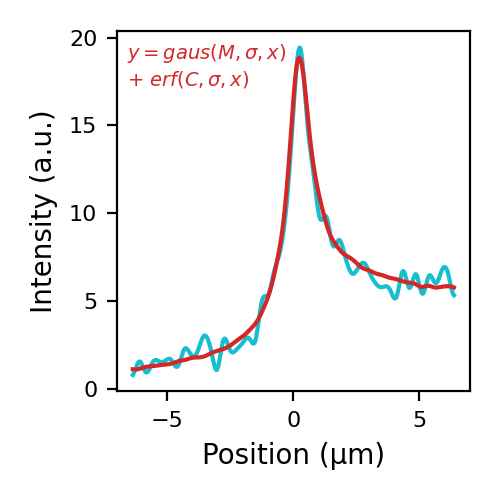

In [80]:
fig, ax = plt.subplots()
x = np.linspace(-25 * 0.255, 25 * 0.255, 500)
ax.plot(x, straight_itp[:, position] / 1000, c='tab:cyan')
ax.plot(x, interp_1d_array(iq.sim_both_full[0][:, position] / 1000, 500), c='tab:red')
ax.set_xlabel('Position (μm)')
ax.set_ylabel('Intensity (a.u.)')
peak = x[np.argmax(straight_itp[:, position])]
ax.tick_params(axis='both', labelsize=8)
ax.text(s=r'$y = gaus(M, \sigma, x)$' + '\n' + r'+ $erf(C, \sigma, x)$', x=0.03, y=0.85, 
        transform=ax.transAxes, color='tab:red', fontsize=7)
fig.set_size_inches(2.5, 2.5)
fig.tight_layout()
fig.savefig('Figs_method_comparison/method2.png', dpi=600, transparent=True)